Name: Arjun Bhan  UNI: AB5666

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random
from torchmetrics.classification import Recall, Accuracy, AUROC, Precision

In [ ]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
!unzip -o smsspamcollection.zip

--2023-12-13 20:58:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [ <=>                ] 198.65K  --.-KB/s    in 0.03s   

2023-12-13 20:58:27 (5.89 MB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
!head -10 SMSSpamCollection

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
ham	Even my brother is not like to speak with me. They treat me like aids patent.
ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
spam	H

In [ ]:
# Loop through the data and make a dataframe with two columns
# label is 0/1 if Not Spam / Spam
spam_ham_array = []
ham_spam_numb = 0
with open('SMSSpamCollection', 'r') as file:
  for i in file:
    ham_spam_iden, text = i.strip().split('\t', 1)
    if ham_spam_iden == 'spam':
      ham_spam_numb = 1
    else:
      ham_spam_numb = 0

    spam_ham_array.append([ham_spam_numb, text])
df = pd.DataFrame(spam_ham_array, columns = ['label','text'])

In [ ]:
df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,1,This is the 2nd time we have tried 2 contact u...
5570,0,Will ü b going to esplanade fr home?
5571,0,"Pity, * was in mood for that. So...any other s..."
5572,0,The guy did some bitching but I acted like i'd...


In [ ]:
df['label'].value_counts()

0    4827
1     747
Name: label, dtype: int64

In [ ]:
text = df.text.values
labels = df.label.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def print_rand_sentence():
    index = random.randint(0, len(text)-1)
    tokens = tokenizer.tokenize(text[index])
    ids = tokenizer.convert_tokens_to_ids(tokens)
    print(tabulate(np.array([tokens, ids]).T, headers = ['Tokens', 'Token IDs']))

print_rand_sentence()

Tokens      Token IDs
--------  -----------
play             2377
##in             2378
space            2686
poker           11662
,                1010
u                1057
?                1029


In [ ]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''

  encode_text = tokenizer.encode_plus(
      text= input_text,
      add_special_tokens = True,
      max_length = 32,
      pad_to_max_length = True,
      return_tensors = 'pt'
      )
  return encode_text


for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids'])
    attention_masks.append(encoding_dict['attention_mask'])

token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
def print_rand_sentence_encoding():
    '''Displays tokens, token IDs and attention mask of a random text sample'''
    index = random.randint(0, len(text) - 1)
    curr_token_id = token_id[index].squeeze().tolist()
    curr_attention_masks = attention_masks[index].squeeze().tolist()

    tokens = tokenizer.convert_ids_to_tokens(curr_token_id)

    print(tabulate((zip(tokens, curr_token_id, curr_attention_masks)), headers = ['Tokens', 'Token IDs', 'Attention Mask']))


print_rand_sentence_encoding()

Tokens      Token IDs    Attention Mask
--------  -----------  ----------------
[CLS]             101                 1
its              2049                 1
ok               7929                 1
,                1010                 1
if               2065                 1
anybody         10334                 1
asks             5176                 1
ab              11113                 1
##t              2102                 1
me               2033                 1
,                1010                 1
u                1057                 1
tel             10093                 1
them             2068                 1
.                1012                 1
.                1012                 1
:                1024                 1
-                1011                 1
p                1052                 1
[SEP]             102                 1
[PAD]               0                 0
[PAD]               0                 0
[PAD]               0                 0


In [ ]:
val_ratio = 0.2
batch_size = 32

train_idx, val_idx = train_test_split(
    range(len(df['label'])),
    test_size = val_ratio,
    stratify = df['label']
)
train_set = TensorDataset(token_id[train_idx], attention_masks[train_idx], labels[train_idx])

val_set = TensorDataset(token_id[val_idx], attention_masks[val_idx], labels[val_idx])

train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

### Load specific versions of the model

In [ ]:

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', output_attentions = False, output_hidden_states = False
)

# See for the optimizer and some learning rates: https://arxiv.org/pdf/1810.04805.pdf
optimizer = AdamW(model.parameters(),
                  lr = 2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Set the model to the right device

In [ ]:
device = torch.device('mps') if (
    torch.backends.mps.is_available() and torch.backends.mps.is_built()
) else torch.device('cpu')



In [ ]:
_ = model.to(device)

epochs = 2

In [ ]:
fine_tune_bert = True

total_parameters = 0


for i, j in model.named_parameters():
  if fine_tune_bert:
    param_amt = j.numel()
    print(i, param_amt, j.requires_grad)
    total_parameters += param_amt
  else:
    if 'classifier' in i:
      total_parameters += param_amt
    else:
      j.requires_grad = False
    param_amt = j.numel()
    print(i, param_amt, j.requires_grad)

assert(total_parameters == 109483778)

bert.embeddings.word_embeddings.weight 23440896 True
bert.embeddings.position_embeddings.weight 393216 True
bert.embeddings.token_type_embeddings.weight 1536 True
bert.embeddings.LayerNorm.weight 768 True
bert.embeddings.LayerNorm.bias 768 True
bert.encoder.layer.0.attention.self.query.weight 589824 True
bert.encoder.layer.0.attention.self.query.bias 768 True
bert.encoder.layer.0.attention.self.key.weight 589824 True
bert.encoder.layer.0.attention.self.key.bias 768 True
bert.encoder.layer.0.attention.self.value.weight 589824 True
bert.encoder.layer.0.attention.self.value.bias 768 True
bert.encoder.layer.0.attention.output.dense.weight 589824 True
bert.encoder.layer.0.attention.output.dense.bias 768 True
bert.encoder.layer.0.attention.output.LayerNorm.weight 768 True
bert.encoder.layer.0.attention.output.LayerNorm.bias 768 True
bert.encoder.layer.0.intermediate.dense.weight 2359296 True
bert.encoder.layer.0.intermediate.dense.bias 3072 True
bert.encoder.layer.0.output.dense.weight 23592

### Train the model

In [ ]:

accuracy = Accuracy(task = 'binary').cpu()
recall = Recall(task = 'binary').cpu()
precision = Precision(task = 'binary').cpu()
auroc = AUROC(task = 'binary').cpu()

In [ ]:
for _ in trange(epochs, desc = 'Epoch'):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        train_output = model(b_input_ids, attention_mask = b_input_mask, labels = b_labels)
        loss = train_output.loss
        logits = train_output.logits

        loss.backward()

        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1


    model.eval()

    val_accuracy = []
    val_precision = []
    val_recall = []
    val_auroc = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            eval_output =  model(b_input_ids, attention_mask = b_input_mask, labels = b_labels)

        probs = torch.softmax(eval_output.logits, dim = 1)[:, 1]

        labels = b_labels.to('cpu')
        predicted_labels = torch.argmax(eval_output.logits, dim = 1).to('cpu')

        val_accuracy.append(accuracy(predicted_labels, labels).item())
        val_recall.append(recall(predicted_labels, labels).item())
        val_precision.append(precision(predicted_labels, labels).item())
        val_auroc.append(auroc(probs, labels).item())

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)))
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)))
    print('\t - Validation AUROC: {:.4f}\n'.format(sum(val_auroc)/len(val_auroc)))

Epoch:  50%|█████     | 1/2 [14:45<14:45, 885.96s/it]


	 - Train loss: 0.1238
	 - Validation Accuracy: 0.9902
	 - Validation Precision: 0.9929
	 - Validation Recall: 0.9171
	 - Validation AUROC: 0.9827



Epoch: 100%|██████████| 2/2 [29:23<00:00, 881.54s/it]


	 - Train loss: 0.0307
	 - Validation Accuracy: 0.9929
	 - Validation Precision: 0.9857
	 - Validation Recall: 0.9505
	 - Validation AUROC: 0.9922



### Test on a specific sentence, see the outcome

In [ ]:
new_sentence = 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'

test_ids = []
test_attention_mask = []

encoding = preprocessing(new_sentence, tokenizer)

test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

with torch.no_grad():
    output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Spam' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Ham'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Predicted Class:  Spam


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', output_attentions = False, output_hidden_states = False
)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('mps') if (
    torch.backends.mps.is_available() and torch.backends.mps.is_built()
) else torch.device('cpu')



In [ ]:
_ = model.to(device)

epochs = 2

In [ ]:
fine_tune_bert = False

total_parameters = 0


for i, j in model.named_parameters():
  if fine_tune_bert:
    param_amt = j.numel()
    print(i, param_amt, j.requires_grad)
    total_parameters += param_amt
  else:
    if 'classifier' in i:
      total_parameters += param_amt
    else:
      j.requires_grad = False
    param_amt = j.numel()
    print(i, param_amt, j.requires_grad)

bert.embeddings.word_embeddings.weight 23440896 False
bert.embeddings.position_embeddings.weight 393216 False
bert.embeddings.token_type_embeddings.weight 1536 False
bert.embeddings.LayerNorm.weight 768 False
bert.embeddings.LayerNorm.bias 768 False
bert.encoder.layer.0.attention.self.query.weight 589824 False
bert.encoder.layer.0.attention.self.query.bias 768 False
bert.encoder.layer.0.attention.self.key.weight 589824 False
bert.encoder.layer.0.attention.self.key.bias 768 False
bert.encoder.layer.0.attention.self.value.weight 589824 False
bert.encoder.layer.0.attention.self.value.bias 768 False
bert.encoder.layer.0.attention.output.dense.weight 589824 False
bert.encoder.layer.0.attention.output.dense.bias 768 False
bert.encoder.layer.0.attention.output.LayerNorm.weight 768 False
bert.encoder.layer.0.attention.output.LayerNorm.bias 768 False
bert.encoder.layer.0.intermediate.dense.weight 2359296 False
bert.encoder.layer.0.intermediate.dense.bias 3072 False
bert.encoder.layer.0.output.d

In [ ]:

accuracy = Accuracy(task = 'binary').cpu()
recall = Recall(task = 'binary').cpu()
precision = Precision(task = 'binary').cpu()
auroc = AUROC(task = 'binary').cpu()

In [ ]:
for _ in trange(epochs, desc = 'Epoch'):

    model.train()

    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()

        train_output = model(b_input_ids, attention_mask = b_input_mask, labels = b_labels)
        loss = train_output.loss
        logits = train_output.logits

        loss.backward()

        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1


    model.eval()

    val_accuracy = []
    val_precision = []
    val_recall = []
    val_auroc = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            eval_output =  model(b_input_ids, attention_mask = b_input_mask, labels = b_labels)

        probs = torch.softmax(eval_output.logits, dim = 1)[:, 1]

        labels = b_labels.to('cpu')
        predicted_labels = torch.argmax(eval_output.logits, dim = 1).to('cpu')

        val_accuracy.append(accuracy(predicted_labels, labels).item())
        val_recall.append(recall(predicted_labels, labels).item())
        val_precision.append(precision(predicted_labels, labels).item())
        val_auroc.append(auroc(probs, labels).item())

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)))
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)))
    print('\t - Validation AUROC: {:.4f}\n'.format(sum(val_auroc)/len(val_auroc)))

Epoch:  50%|█████     | 1/2 [05:12<05:12, 312.26s/it]


	 - Train loss: 0.4364
	 - Validation Accuracy: 0.8629
	 - Validation Precision: 0.0000
	 - Validation Recall: 0.0000
	 - Validation AUROC: 0.5992



Epoch: 100%|██████████| 2/2 [10:18<00:00, 309.20s/it]


	 - Train loss: 0.4030
	 - Validation Accuracy: 0.8629
	 - Validation Precision: 0.0000
	 - Validation Recall: 0.0000
	 - Validation AUROC: 0.6856



In [ ]:
new_sentence = 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'

test_ids = []
test_attention_mask = []

encoding = preprocessing(new_sentence, tokenizer)

test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

with torch.no_grad():
    output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Spam' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Ham'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Predicted Class:  Ham


### Questions

Question 1: Run the above by fine tuning bert and the classfier head and by not doing this (using BERT as a feature encoder). What is the gap between this?

Solution:


fine tuning BERT and the classfier head

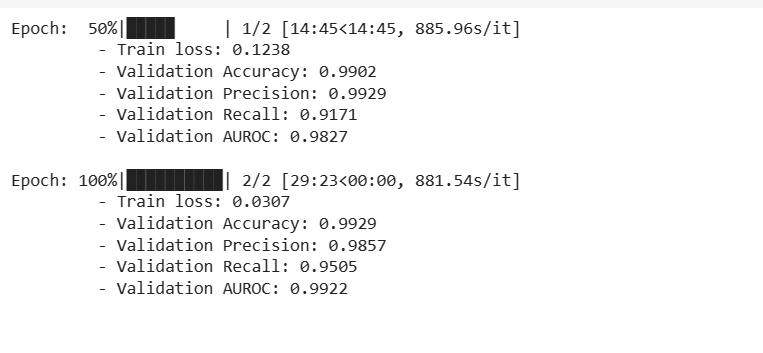

Not fine tuning BERT and the classfier head

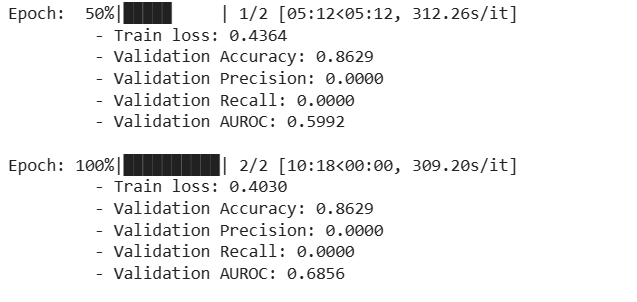

As we can see from the results fine tuning BERT and the classfier head was far more effective than not doing so. When we fine tune BERT and the classifier head it returned far superior result for all performance metrics we measured. The model with fine tuning BERT and the classfier head performed excellent on the data having great results with its performance metrics. The very low precision and recall score for the model without fine tuning BERT and the classfier head seems to imply that the model had a very high false positive and false negative amount. This means that the model is having issues in identifying both the positive cases and negative cases. This makes sense since fine tuning BERT and the classifier head allows the model to adjust its pre-learned embeddings and weights in order to be more effective at understanding the data.